In [2]:
import numpy as np
import matplotlib.pyplot as plt
import sympy as sp
from sympy.geometry.entity import GeometryEntity
from mpl_toolkits.mplot3d import Axes3D
import mpl_toolkits.mplot3d.art3d as art3d
Polygon3D = lambda *a: GeometryEntity.__new__(sp.Polygon, *a)

from IPython.display import Latex as LatexFactory
from IPython.display import HTML as HTMLFactory
from IPython.display import display

def _setFormatToSvg():
  from IPython.display import set_matplotlib_formats
  from IPython import get_ipython
  ipy = get_ipython()
  if ipy == None:
    return
  ipy.run_line_magic('matplotlib', 'inline')
  sp.init_printing()
  set_matplotlib_formats('svg')

_setFormatToSvg()

def concatLatex(*args):
  res = ""
  for arg in args:
    if isinstance(arg, str):
      res += " "+arg+" "
    elif hasattr(arg, '_repr_latex_'):
      res += " "+arg._repr_latex_()+" "
    elif hasattr(arg, '__repr__'):
      res += " "+arg.__repr__()+" "
    elif hasattr(arg, '__str__'):
      res += " "+arg.__str__()+" "

  return LatexFactory(res)

# just like print
def pprint(*args):
  display(concatLatex(*args))

def deg(a):
  return float(a/sp.pi*180)
def rad(a):
  return a*sp.pi/180
def D(a,b):
  return a.distance(b)
def nrm(p):
  return p/abs(p)
def norm(plane):
  return nrm(sp.Point(*plane.normal_vector))
def lerp(a,b,x):
  return a+x*(b-a)

def _is3d(plt):
  return hasattr(plt, "gca") and callable(plt.gca) and isinstance(plt.gca(), Axes3D)

def _plotLine(X, p1, p2):
  p1 = np.array([float(e) for e in p1])
  p2 = np.array([float(e) for e in p2])
  return zip(*[lerp(p1,p2,e) for e in X])

def _plotPolygon(poly,bool=False):
  if hasattr(poly, "vertices"):
    verts = list(poly.vertices)
  else:
    verts = list(poly)
  if bool:
    verts.append(verts[0])
  return zip(*[[float(e) for e in point] for point in verts])

def _darwPolygon(zipped, label, plt):
  t = _nextPolyStyle()
  ls = list(zipped)

  if(t & 1):
    if not isinstance(plt, Axes3D):
      plt.fill(*ls, zorder=-1, alpha=.3)
    else:
      vert3d = [list(zip(*ls))]
      ploy3d = art3d.Poly3DCollection(vert3d)
      ploy3d.set_alpha(.3)
      ploy3d.set_facecolor(next(plt._get_patches_for_fill.prop_cycler)['color'])
      plt.add_collection3d(ploy3d)

  if(t & 2):
    for i in range(len(ls)):
      ls[i] = np.append(ls[i], ls[i][0])
    plt.plot(*ls, label=label, zorder=0)

def _annotatePoints(points, plt=plt):
  if _is3d(plt):
    plt = plt.gca()

  for k in points:
    if k[0] == ' ':
      continue
    point = [float(e) for e in points[k]]
    if hasattr(plt, 'xlim'):
      point = point[:2]
    # plt.scatter(*point, label=k, zorder=1)
    plt.scatter(*point, zorder=1)
    if hasattr(plt, 'xlim'):
      plt.annotate(k, point[:2], xytext=[5,0], textcoords='offset points')
    else:
      plt.text(*point, " "+k)

  if hasattr(plt, 'xlim'):
    plt.xlim(min(float(points[k].x) for k in points)-.5, max(float(points[k].x) for k in points)+.5)
    plt.ylim(min(float(points[k].y) for k in points)-.5, max(float(points[k].y) for k in points)+.5)
  else:
    plt.set_xlim(min(float(points[k].x) for k in points)-.5, max(float(points[k].x) for k in points)+.5)
    plt.set_ylim(min(float(points[k].y) for k in points)-.5, max(float(points[k].y) for k in points)+.5)
    plt.set_zlim(min(float(points[k].z) for k in points)-.5, max(float(points[k].z) for k in points)+.5)

def _nextPolyStyle():
  global _symplot_poly_config
  t = _symplot_poly_config
  if type(t) == list:
    t = t[0]
    _symplot_poly_config = _symplot_poly_config[1:]
    if _symplot_poly_config == []:
      _symplot_poly_config = t
  return t

def _symplot_dict(d, plt=plt):
  X = np.linspace(0,1,2)
  points = dict()
  ax = plt.gca()
  if _is3d(plt):
    plt = plt.gca()

  for label,e in d.items():
    if isinstance(e, sp.Point):
      points[label] = e
    elif isinstance(e, sp.Segment):
      plt.plot(*_plotLine(X, e.p1, e.p2), label=label, zorder=0)
      points[' '+label+' 0'] = e.p1
      points[' '+label+' 1'] = e.p2
    elif isinstance(e, sp.Ray):
      plt.plot(*_plotLine(X*10, e.p1, e.p2), label=label, zorder=0)
      points[' '+label+' 0'] = e.p1
    elif isinstance(e, sp.Line):
      plt.plot(*_plotLine((X-.5)*10, e.p1, e.p2), label=label, zorder=0)
    elif isinstance(e, sp.Plane):
      x,y,z = sp.symbols('x y z')
      eq = e.equation(x,y,z)
      base = [(10,10),(-10,10),(-10,-10),(10,-10)]
      if e.normal_vector[2] == 0:
        eqs = sp.solve(eq,x)[0]
        planepoints = map(lambda a: sp.Point(eqs.subs([(y,a[0]),(x,a[1])]), *a), base)
      else:
        eqs = sp.solve(eq,z)[0]
        planepoints = map(lambda a: sp.Point(*a, eqs.subs([(x,a[0]),(y,a[1])])), base)
      _darwPolygon(_plotPolygon(planepoints), label, plt)
    elif isinstance(e, sp.Polygon):
      _darwPolygon(_plotPolygon(e), label, plt)

      for i,vert in enumerate(e.vertices):
        points[' '+label+' '+str(i)] = vert
    elif isinstance(e, sp.Ellipse):
      from matplotlib.patches import Ellipse
      center = [float(e) for e in e.center]
      if len(center)==2:
        center.append(0)
      x,y,z = center
      vr = e.vradius
      hr = e.hradius

      t = _nextPolyStyle()
      ps = []

      if(t & 1):
        facecolor = next(ax._get_patches_for_fill.prop_cycler)['color']
        ps.append(Ellipse( (x, y), hr*2, vr*2, zorder=-1, alpha=.3, facecolor=facecolor ))

      if(t & 2):
        edgecolor = next(ax._get_lines.prop_cycler)['color']
        ps.append(Ellipse( (x, y), hr*2, vr*2, label=label, zorder=0, fill=False, edgecolor=edgecolor, linewidth=1.5 ))

      for p in ps:
        ax.add_patch(p)
        if isinstance(plt, Axes3D):
          art3d.pathpatch_2d_to_3d(p, z=z, zdir="z")

      points[' '+label+' 1'] = sp.Point(x+hr, y+vr, z)
      points[' '+label+' 2'] = sp.Point(x-hr, y-vr, z)

  _annotatePoints(points, plt)
  pass

_symplot_poly_config = 1
def symplot(*a, **d):
  global _symplot_poly_config
  if(len(d) == 0 and len(a) == 1 and type(a[0]) == dict):
    _symplot_dict(*a)
  elif(len(a) == 0):
    _symplot_dict(d)
  elif(len(d) == 0 and len(a) == 2 and type(a[0]) == str):
    r = dict()
    glob = a[1]
    s = a[0]
    for name in s.split(' '):
      r['$'+sp.latex(sp.Symbol(name))+'$'] = glob[name]
    if "_symplot_poly_config" in glob:
      _symplot_poly_config = glob["_symplot_poly_config"]
    _symplot_dict(r)

if __name__ != "__main__":
  display(HTMLFactory("""
    <i>LatexFactory</i> is a module I wrote,
    Ð¿Ð¾Ñ‚Ð¾Ð¼Ñƒ Ñ‡Ñ‚Ð¾ Ð¼Ð½Ðµ <span style="font-family: lobster, cursive">Ð»ÐµÐ½ÑŒ</span> ÐºÐ¾Ð¿Ð¸Ñ€Ð¾Ð²Ð°Ñ‚ÑŒ Ð¾Ð´Ð¸Ð½ Ð¸ Ñ‚Ð¾Ñ‚ Ð¶Ðµ ÐºÐ¾Ð´ Ð² ÐºÐ°Ð¶Ð´Ñ‹Ð¹ notebook. <br/>
    It imports all the required libraries and defines some extra pretty printing functions.
    <img src="https://i.imgur.com/Kn3sEkN.png" style="width: 250px"/>
  """))


# Занятие 11
# Алгебра

##  Плоские многоугольники в пространстве. 
### Задание 1.

Построить правильный шестиугольник с одной из вершин в начале координат, соседняя вершина находится на положительной части оси ОХ на расстоянии 3 от нее, центр шестиугольника расположен над осью ОХ.

Изобразить на рисунке.

Найти углы и длины сторон шестиугольника в плоскости $\alpha$: $2x-3y+5z-20=0$, который мог бы отбрасывать такую тень (правильный шестиугольник), если лучи света 
перпендикулярны плоскости $\alpha$.

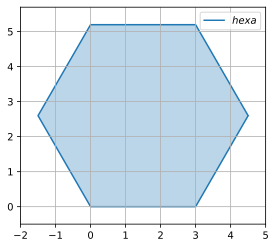

In [3]:
x = sp.Plane(sp.Point(0, 0, 0), sp.Point(1, 5, 0), sp.Point(3, 1, 0))
O = sp.Point(3 / sp.S(2), sp.sqrt(3**2 - 1.5**2), 0)
hexa = sp.RegularPolygon(O, 3, 6)
vert = hexa.vertices
hexa3D = Polygon3D(vert[0], vert[1], vert[2], vert[3], vert[4], vert[5])
display(hexa.centroid)
alpha = sp.Plane(sp.Point(0, 0, 4), sp.Point(10, 0, 0), sp.Point(10, 5, 3))
points = [alpha.projection(P) for P in hexa.vertices]
sides = []
P1 = points[0]
P2 = points[1]
P3 = points[2]
P4 = points[3]
P5 = points[4]
P6 = points[5]
S1 = sp.Segment(P1, P2)
S2 = sp.Segment(P3, P2)
S3 = sp.Segment(P3, P4)
S4 = sp.Segment(P4, P5)
S5 = sp.Segment(P5, P6)
S6 = sp.Segment(P1, P6)
display(alpha.equation()) # проверка
_symplot_poly_config = 3
symplot("hexa", globals())
plt.gca().set_aspect('equal')
plt.legend(loc='best')
plt.grid()

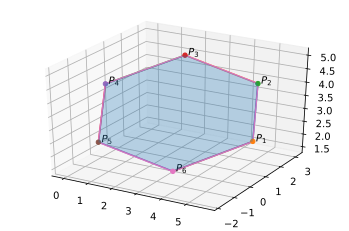

In [4]:
plt.subplot(111, projection='3d')
hexProj = Polygon3D(P1, P2, P3, P4, P5, P6)
symplot("S1 S2 S3 S4 S5 S6 P1 P2 P3 P4 P5 P6 hexProj", globals())

In [5]:
print("Углы между сторонами этого шестиугольника:")
a1 = float(S1.angle_between(S2) / sp.pi * 180)
a2 = float(S3.angle_between(S2) / sp.pi * 180)
a3 = 180 - float(S3.angle_between(S4) / sp.pi * 180)
a4 = 180 - float(S4.angle_between(S5) / sp.pi * 180)
a5 = float(S5.angle_between(S6) / sp.pi * 180)
a6 = float(S6.angle_between(S1) / sp.pi * 180)
display(a1, a2, a3, a4, a5, a6, a1 + a2 + a3 + a4 + a5 + a6)

Углы между сторонами этого шестиугольника:


In [6]:
print("Стороны многоугольника:")
display(float(S1.length), float(S2.length), float(S3.length), float(S4.length), float(S5.length), float(S6.length))

Стороны многоугольника:


### Задание 2.
Для правильного шестиугольника из задания 1 найти тень, отбрасываемую им на плоскость $\alpha$, если светит точечный источник света из точки М(1,2,-10).

C:\Users\deaddrunkspirit\Anaconda3\lib\site-packages\sympy\geometry\point.py:147: UserWarning: Dimension of (9/2, 64951905283833/25000000000000) needs to be changed from 2 to 3.
  warnings.warn(message)
C:\Users\deaddrunkspirit\Anaconda3\lib\site-packages\sympy\geometry\point.py:147: UserWarning: Dimension of (3, 3*sqrt(3)/2 + 64951905283833/25000000000000) needs to be changed from 2 to 3.
  warnings.warn(message)
C:\Users\deaddrunkspirit\Anaconda3\lib\site-packages\sympy\geometry\point.py:147: UserWarning: Dimension of (0, 3*sqrt(3)/2 + 64951905283833/25000000000000) needs to be changed from 2 to 3.
  warnings.warn(message)
C:\Users\deaddrunkspirit\Anaconda3\lib\site-packages\sympy\geometry\point.py:147: UserWarning: Dimension of (-3/2, 64951905283833/25000000000000) needs to be changed from 2 to 3.
  warnings.warn(message)
C:\Users\deaddrunkspirit\Anaconda3\lib\site-packages\sympy\geometry\point.py:147: UserWarning: Dimension of (0, 64951905283833/25000000000000 - 3*sqrt(3)/2) needs 

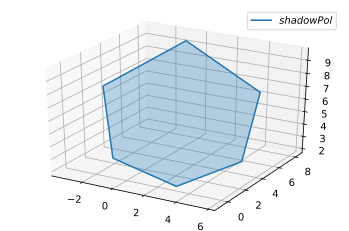

In [7]:
M = sp.Point(1, 2, -10)
Rays = [sp.Ray(M, P) for P in hexa.vertices]
shadowM = [i.intersection(alpha)[0] for i in Rays]
shadowPol = Polygon3D(shadowM[0], shadowM[1], shadowM[2], shadowM[3], shadowM[4], shadowM[5])
plt.subplot(111, projection='3d')
symplot("shadowPol", globals())
plt.legend(loc = "best")

### Задание 3
Постоить часть тени, отбрасываемой треугольником ABC, A(1,2,15), B(3,1,12), C(7,5,11) на плоскость  $\alpha$, пересекающуюся с тенью из Задания 2. На АВС светит точечный источник из точки Р(4,5,25). 

Изобразить на рисунке проекцию тени на плоскость $x=0$.

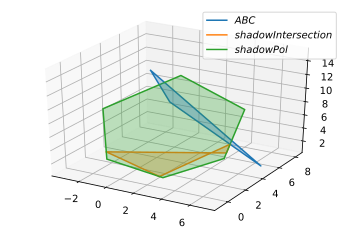

In [8]:
A = sp.Point(1, 2, 15)
B = sp.Point(3, 1, 12)
C = sp.Point(7, 5, 1)
P = sp.Point(4, 5, 25)
z = sp.Plane(sp.Point(0, 1, 2), sp.Point(0, 0, 0), sp.Point(0, 2, 3))
ABC = Polygon3D(A, B, C)
Rays = [sp.Ray(P, N) for N in ABC.vertices]
shadowABCPoints = [i.intersection(alpha)[0] for i in Rays]
shadowABC = Polygon3D(shadowABCPoints[0], shadowABCPoints[1], shadowABCPoints[2])
shadowIntersect = sp.intersection(shadowABC, shadowPol)
shadowIntersection = Polygon3D(shadowIntersect[0], shadowIntersect[1], shadowIntersect[2], shadowIntersect[3]) 
plt.subplot(111, projection='3d')
symplot("ABC shadowIntersection shadowPol", globals())
plt.legend(loc = "best")

### Задание 4

Найти угол между проекцией прямой АВ на плоскость $\alpha$ и осью ОХ.

In [9]:
AB = sp.Line(A, B)
AB1 = alpha.projection_line(AB)
OX = sp.Line(sp.Point(0, 0, 0), sp.Point(1, 0, 0))
display(float(AB1.angle_between(OX) * 180 / sp.pi))

###  Индивидуальное задание

Даны точки А,В,С. Построить параллелограмм ABCD, его тень, отбрасываемую при точечном источнике света, расположеном в точке М, на плоскость $\gamma$, проходящую через начало координат под углом 45 градусов к плоскости АВС. Найти площадь ABCD, его тени и ее проекции на плоскость $y=0$.  Изобразить на рисунке проекцию тени на плоскость $y=0$.


In [10]:
# A(7,3,4), B(11,8,3), C(5,5,6), M(2,11,18)

#A = sp.Point(7, 3, 4)
#B = sp.Point(11, 8, 3)
#C = sp.Point(5, 5, 6)
#y = sp.Plane(sp.Point(0, 0, 0), sp.Point(1, 0, 1), sp.Point(3, 0, 0))
#AB = sp.Segment(B, A)
#BC = sp.Segment(C, B)
#CA = sp.Segment(C, A)
#AD = BC.parallel_line(A)
#CD = AB.parallel_line(C)
#D = sp.intersection(AD, CD)[0]
#AD = sp.Segment(A, D)
#CD = sp.Segment(C, D)
#ABCD = Polygon3D(A, B, C, D)
#display(D)
#plt.subplot(111, projection='3d')
#symplot("A B C D AB BC CD AD ABCD", globals())
#plt.legend(loc='lower right')
#plt.grid()

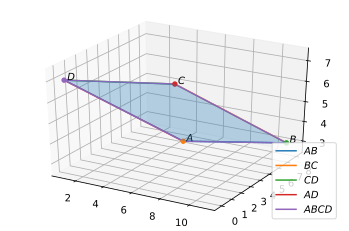

In [11]:
t1 = sp.symbols("t1")

A = sp.Point(7, 3, 4)
B = sp.Point(11, 8, 3)
C = sp.Point(5, 5, 6)
ABC = sp.Plane(A,B,C)

y = sp.Plane(sp.Point(0, 0, 0), sp.Point(1, 0, 1), sp.Point(3, 0, 0))

AB = sp.Segment(B, A)
BC = sp.Segment(C, B)
CA = sp.Segment(C, A)
AD = BC.parallel_line(A)
CD = AB.parallel_line(C)
D = sp.intersection(AD, CD)[0]
AD = sp.Segment(A, D)
CD = sp.Segment(C, D)
ABCD = Polygon3D(A,B,C,D)
display(D)

plt.subplot(111, projection='3d')
symplot("A B C D AB BC CD AD ABCD", globals())
plt.legend(loc='lower right')
plt.grid()

In [ ]:
t1 = sp.symbols('t1')
perp1 = ABC.perpendicular_line(O)
perp2 = y.perpendicular_line(O)
S1 = sp.Segment(O, perp1.p2)
S2 = sp.Segment(O, perp2.p2)
S3 = sp.Segment(perp1.p2, perp2.p2)

line1 = sp.Line(perp1.p2, perp2.p2)
display(line1.p1, line1.p2)

vector = line1.p1 - line1.p2
point = line1.p2

x1 = point.x + vector.x * t1
y1 = point.y + vector.y * t1
z1 = point.z + vector.z * t1

angle = y.angle_between(ABC) - sp.pi / 4

segment = sp.Segment(O, sp.Point(x1, y1, z1))

res = list(sp.solveset(segment.angle_between(S2) - angle, t1, sp.S.Reals))

point = sp.Point(x1.subs(t1, res[0]), y1.subs(t1, res[0]), z1.subs(t1, res[0]))

pointLine = sp.Line(O, point) # ?
norm = pointLine.p2 - pointLine.p1 
gamma = sp.Plane(O, normal_vector = norm)
display(float(ABC.angle_between(gamma) * 180 / sp.pi))

plt.subplot(111, projection = '3d')
symplot("S1 S2 S3 point", globals())
plt.grid()

In [20]:
M = sp.Point(2, 11, 18)
MA = sp.Line(M, A)
MB = sp.Line(M, B)
MC = sp.Line(M, C)
MD = sp.Line(M, D)
MAgamma = MA.intersection(gamma)
MBgamma = MB.intersection(gamma)
MCgamma = MC.intersection(gamma)
MDgamma = MD.intersection(gamma)
Aproj = y.projection(MAgamma[0])
Bproj = y.projection(MBgamma[0])
Cproj = y.projection(MCgamma[0])
Dproj = y.projection(MDgamma[0])
ACgamma = sp.Segment(MAgamma[0], MCgamma[0])
BDgamma = sp.Segment(MBgamma[0], MDgamma[0])
S = 0.5 * ACgamma.length * BDgamma.length * sp.sin(ACgamma.angle_between(BDgamma)) 
float(S)

In [21]:
AC = sp.Segment(A,C)
BD = sp.Segment(B,D)
S = 0.5 * AB.length * CD.length * sp.sin(AC.angle_between(BD))
float(S)

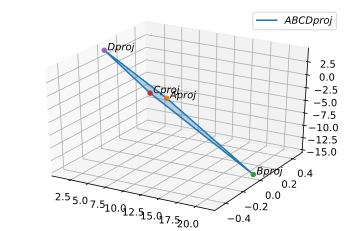

In [22]:
plt.subplot(111, projection = '3d')
ABCDproj = Polygon3D(Aproj, Bproj, Cproj, Dproj)
symplot("Aproj Bproj Cproj Dproj ABCDproj", globals())
plt.grid()
plt.legend(loc = "best")